In [46]:
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt

In [47]:
def vcol(x):
    return x.reshape((x.size, 1))

In [48]:
def vrow(x):
    return x.reshape((1, x.size))

In [49]:
def load(filename):
    DList=[]
    lablesList=[]
    #La classe puo cambiare
    with open(filename) as f:
        for line in f:
            line=line.strip()
            try:
                fields=line.split(',')[0:-1] # prendo tutti i campi tranne l'ultimo ovvero l etichetta
                fields=vcol(np.array([float(x) for x in fields]))
                DList.append(fields)
                label=line.split(',')[-1].strip()
                lablesList.append(label)
            except:
                pass
    return np.hstack(DList),np.array(lablesList,dtype=np.int32)
            

In [50]:
def split_db_2to1(D, L, seed=0):
    nTrain = int(D.shape[1]*2.0/3.0)
    np.random.seed(seed)
    idx = np.random.permutation(D.shape[1])
    idxTrain = idx[0:nTrain]
    idxTest = idx[nTrain:]
    DTR = D[:, idxTrain]
    DVAL = D[:, idxTest]
    LTR = L[idxTrain]
    LVAL = L[idxTest]
    return (DTR, LTR), (DVAL, LVAL)

In [51]:
D,lables=load('trainData.txt')
(DTR,LTR), (DVAL,LVAL)=split_db_2to1(D,lables)


In [52]:
def compute_confusion_matrix(predictedLabels, classLabels):
    nClasses = classLabels.max() + 1
    M = np.zeros((nClasses, nClasses), dtype=np.int32) #
    #### M[i,j] = number of instances of class i that were predicted to be class j
    for i in range(classLabels.size):
        M[predictedLabels[i], classLabels[i]] += 1
    return M


In [53]:
def compute_empirical_Bayes_risk_binary(predictedLabels, classLabels, prior, Cfn, Cfp, normalize=True):
    "Commpute actual DCF"
    CM=compute_confusion_matrix(predictedLabels, classLabels)
    # Pfn (falsi negativi / tutti i positivi)
    # CM[0,1] = numero di campioni di classe 1 (positivi) predetti come classe 0 (negativi)
    # CM[1,1] = numero di campioni di classe 1 (positivi) predetti come classe 1 (positivi)
    Pfn = CM[0,1] / (CM[0,1] + CM[1,1]) if (CM[0,1] + CM[1,1]) > 0 else 0
    
    # Pfp (falsi positivi / tutti i negativi)
    # CM[1,0] = numero di campioni di classe 0 (negativi) predetti come classe 1 (positivi)
    # CM[0,0] = numero di campioni di classe 0 (negativi) predetti come classe 0 (negativi)
    Pfp = CM[1,0] / (CM[0,0] + CM[1,0]) if (CM[0,0] + CM[1,0]) > 0 else 0

    bayesError=prior*Pfn*Cfn+(1-prior)*Pfp*Cfp
    if normalize:
        return bayesError / np.minimum(prior * Cfn, (1-prior)*Cfp)
    return bayesError

In [54]:
def compute_optimal_Bayes_binary_llr(llr, prior, Cfn, Cfp):
    th = -np.log( (prior * Cfn) / ((1 - prior) * Cfp) )
    return np.int32(llr > th)

In [55]:
# Compute empirical Bayes (DCF or actDCF) risk from llr with optimal Bayes decisions
def compute_empirical_Bayes_risk_binary_llr_optimal_decisions(llr, classLabels, prior, Cfn, Cfp, normalize=True):
    predictedLabels = compute_optimal_Bayes_binary_llr(llr, prior, Cfn, Cfp)
    return compute_empirical_Bayes_risk_binary(predictedLabels, classLabels, prior, Cfn, Cfp, normalize=normalize)

In [56]:
#Meglio perche non calcoli la matrice di confusione ogni volta
def compute_minDCF_binary(llr, classLabels, prior, Cfn, Cfp, returnThreshold=False):
    # Ordina i punteggi e le etichette
       
    # Calcola il numero di campioni positivi e negativi
    n_pos = (classLabels == 1).sum()
    n_neg = (classLabels == 0).sum()
    
    # Inizializza il DCF minimo
    min_dcf = float('inf')
    best_threshold = None
    
    # Considera ogni valore unico di llr come soglia
    thresholds = np.unique(np.concatenate([[-np.inf], llr, [np.inf]]))
    
    for t in thresholds:
        # Calcola le predizioni per questa soglia
        predictions = (llr > t).astype(np.int32)
        
        # Calcola il numero di falsi negativi e falsi positivi
        fn = np.sum((predictions == 0) & (classLabels == 1))
        fp = np.sum((predictions == 1) & (classLabels == 0))
        
        # Calcola i tassi di errore
        fnr = fn / n_pos if n_pos > 0 else 0  # False negative rate
        fpr = fp / n_neg if n_neg > 0 else 0  # False positive rate
        
        # Calcola il DCF normalizzato
        dcf = (prior * Cfn * fnr + (1 - prior) * Cfp * fpr) / np.minimum(prior * Cfn, (1 - prior) * Cfp)
        
        # Aggiorna il minimo se necessario
        if dcf < min_dcf:
            min_dcf = dcf
            best_threshold = t
    
    if returnThreshold:
        return min_dcf, best_threshold
    else:
        return min_dcf

Apply the SVM to the project data. Start with the linear model (to avoid excessive training time we
consider only the models trained with K = 1.0). Train the model with different values of C. As for
logistic regression, you should employ a logarithmic scale for the values of C. Reasonable values are
given by numpy.logspace(-5, 0, 11). Plot the minDCF and actDCF (πT = 0.1) as a function of C
(again, use a logarithmic scale for the x-axis).

### Linear SVM

In [57]:
def train_dual_SVM_linear(DTR,LTR,C,K=1):
    """
    Addestra una SVM lineare usando la formulazione duale
    
    Parameters:
    -----------
    DTR : numpy.ndarray
        Matrice dei dati di training (features x samples)
    LTR : numpy.ndarray
        Array delle etichette di training (0 o 1)
    C : float
        Parametro di regolarizzazione (alto C = meno regolarizzazione)
    K : float
        Parametro per controllare la regolarizzazione del bias
        
    Returns:
    --------
    w : numpy.ndarray
        Vettore dei pesi
    b : float
        Termine di bias
    """

    # 1. Converti le etichette da {0,1} a {-1,+1}
    ZTR=LTR*2.0 - 1.0

    # 2. Estendi la matrice dei dati aggiungendo una riga di K
    # Questo permette di includere il bias nel vettore dei pesi

    DTR_EXT= np.vstack([DTR,np.ones((1,DTR.shape[1]))*K])

    # 3. Calcola la matrice H per il problema duale
    # H_ij = z_i * z_j * x_i^T * x_j

    H= np.dot(DTR_EXT.T,DTR_EXT)* vcol(ZTR) * vrow(ZTR) 

     # 4. Definisci la funzione obiettivo duale e il suo gradiente

    def fOpt(alpha):
        """
        Funzione obiettivo duale (da minimizzare)
        L_D(alpha) = 1/2 * alpha^T * H * alpha - alpha^T * 1
        """
        Ha = H @ vcol(alpha)
        loss = 0.5 * (vrow(alpha) @ Ha).ravel() - alpha.sum()
        grad = Ha.ravel() - np.ones(alpha.size)
        return  loss, grad
    
    # 5. Ottimizza usando L-BFGS-B con vincoli box

    alphaStar, _, _ = scipy.optimize.fmin_l_bfgs_b(
        fOpt,                                    # funzione obiettivo
        np.zeros(DTR_EXT.shape[1]),          # punto iniziale
        bounds=[(0, C) for i in LTR],           # vincoli 0 <= alpha_i <= C
        factr=np.nan,                        # precisione (nan = usa solo pgtol)
        pgtol=1e-5                              # tolleranza sul gradiente
    )

    # 6. Calcola la soluzione primale dal duale
    # w* = sum_i(alpha_i * z_i * x_i)
    w_hat = (vrow(alphaStar) * vrow(ZTR) * DTR_EXT).sum(1)


    # 7. Estrai w e b dalla soluzione estesa
    w = w_hat[0:DTR.shape[0]]  # primi D elementi sono w
    b = w_hat[-1] * K          # ultimo elemento è b/K, quindi moltiplica per K

    # 8. Calcola e verifica il duality gap
    def primalLoss(w_hat):
        """Calcola il valore della funzione obiettivo primale"""
        S = (vrow(w_hat) @ DTR_EXT).ravel()
        return 0.5 * np.linalg.norm(w_hat)**2 + C * np.maximum(0, 1 - ZTR * S).sum()
    
    primalLoss_value = primalLoss(w_hat)
    dualLoss_value = -fOpt(alphaStar)[0]
    duality_gap = primalLoss_value - dualLoss_value
    
    print('SVM - C %e - K %e - primal loss %e - dual loss %e - duality gap: %e' % 
          (C, K, primalLoss_value, dualLoss_value, duality_gap))
    
    return w, b, duality_gap

### Kernel SVM

In [58]:
def polyKernel(degree, c):
    """
    Crea una funzione kernel polinomiale: K(x1, x2) = (x1^T x2 + c)^d
    
    Parameters:
    -----------
    degree : int
        Grado del polinomio
    c : float
        Termine costante (c=0 per kernel omogeneo, c>0 per non omogeneo)
    """
    def polyKernelFunc(D1,D2):
        return (np.dot(D1.T, D2) + c) ** degree
    return polyKernelFunc


In [59]:
def rbfKernel(gamma):
    """
    Crea una funzione kernel RBF: K(x1, x2) = exp(-gamma * ||x1 - x2||^2)
    
    Parameters:
    -----------
    gamma : float
        Parametro che controlla la larghezza del kernel
    """
    def rbfKernelFunc(D1, D2):
        # Fast method: ||x-y||^2 = ||x||^2 + ||y||^2 - 2x^T y
        D1Norms = (D1**2).sum(0)  # norma al quadrato di ogni colonna di D1
        D2Norms = (D2**2).sum(0)  # norma al quadrato di ogni colonna di D2
        Z = vcol(D1Norms) + vrow(D2Norms) - 2 * np.dot(D1.T, D2)
        return np.exp(-gamma * Z)
    return rbfKernelFunc


In [60]:
def train_dual_SVM_kernel(DTR, LTR, C, kernelFunc, eps=1.0):
    """
    Addestra una SVM con kernel usando la formulazione duale
    
    Parameters:
    -----------
    DTR : numpy.ndarray
        Matrice dei dati di training (features x samples)
    LTR : numpy.ndarray
        Array delle etichette di training (0 o 1)
    C : float
        Parametro di regolarizzazione
    kernelFunc : function
        Funzione kernel K(x1, x2)
    eps : float
        Termine per aggiungere bias regolarizzato (eps=ξ²)
        
    Returns:
    --------
    fScore : function
        Funzione che calcola gli score per nuovi campioni
    """

    # 1. Converti le etichette da {0,1} a {-1,+1}
    ZTR = LTR * 2.0 - 1.0

    # 2. Calcola la matrice kernel K con aggiunta del termine eps
    # K_ij = k(x_i, x_j) + eps
    # Il termine eps corrisponde ad aggiungere un bias regolarizzato
    K = kernelFunc(DTR, DTR) + eps

    # 3. Calcola la matrice H per il problema duale
    # H_ij = z_i * z_j * K_ij
    H = vcol(ZTR) * vrow(ZTR) * K

    # 4. Definisci la funzione obiettivo duale
    def fOpt(alpha):
        """
        Funzione obiettivo duale (da minimizzare)
        L_D(alpha) = 1/2 * alpha^T * H * alpha - alpha^T * 1
        """
        Ha = H @ vcol(alpha)
        loss = 0.5 * (vrow(alpha) @ Ha).ravel() - alpha.sum()
        grad = Ha.ravel() - np.ones(alpha.size)
        return loss, grad

    # 5. Ottimizza usando L-BFGS-B
    alphaStar, _, _ = scipy.optimize.fmin_l_bfgs_b(
        fOpt,
        np.zeros(DTR.shape[1]),
        bounds=[(0, C) for i in LTR],
        factr=np.nan,
        pgtol=1e-5
    )
    # 6. Calcola la funzione obiettivo primale per verificare
    def primalLoss(alpha):
        """
        Calcola il valore primale usando la relazione primale-duale
        J(w*) = 1/2 * alpha^T * H * alpha + C * sum(max(0, 1 - H_i * alpha))
        """
        Ha = H @ vcol(alpha)
        return 0.5 * (vrow(alpha) @ Ha).sum() + C * np.maximum(0, 1 - Ha).sum()
    
    primalLoss_value = primalLoss(alphaStar)
    dualLoss_value = -fOpt(alphaStar)[0]
    duality_gap = primalLoss_value - dualLoss_value
    print('SVM (kernel) - C %e - primal loss %e - dual loss %e - duality gap %e' % (C, primalLoss_value, dualLoss_value, primalLoss_value - dualLoss_value))
    # 7. Crea la funzione per calcolare gli score di nuovi campioni
    def fScore(DTE):
        """
        Calcola gli score per i campioni in DTE
        s(x) = sum_i(alpha_i * z_i * k(x_i, x)) dove alpha_i > 0
        
        Parameters:
        -----------
        DTE : numpy.ndarray
            Matrice dei dati di test (features x samples)
            
        Returns:
        --------
        scores : numpy.ndarray
            Array degli score per ogni campione
        """
        K = kernelFunc(DTR, DTE) + eps
        H = vcol(alphaStar) * vcol(ZTR) * K
        return H.sum(0)
    return fScore, duality_gap    

=== Linear SVM with Original Features ===
Training with K=1.0
Training SVM with C=1.0e-05
SVM - C 1.000000e-05 - K 1.000000e+00 - primal loss 4.000000e-02 - dual loss -0.000000e+00 - duality gap: 4.000000e-02
Training SVM with C=3.2e-05


C:\Users\domen\AppData\Local\Temp\ipykernel_2740\655793095.py:78: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('SVM - C %e - K %e - primal loss %e - dual loss %e - duality gap: %e' %


SVM - C 3.162278e-05 - K 1.000000e+00 - primal loss 1.193533e-01 - dual loss 1.193533e-01 - duality gap: -4.163336e-17
Training SVM with C=1.0e-04
SVM - C 1.000000e-04 - K 1.000000e+00 - primal loss 3.290170e-01 - dual loss 3.290170e-01 - duality gap: -1.110223e-16
Training SVM with C=3.2e-04
SVM - C 3.162278e-04 - K 1.000000e+00 - primal loss 7.734636e-01 - dual loss 7.734636e-01 - duality gap: 1.411750e-09
Training SVM with C=1.0e-03
SVM - C 1.000000e-03 - K 1.000000e+00 - primal loss 1.787902e+00 - dual loss 1.787902e+00 - duality gap: 1.529857e-08
Training SVM with C=3.2e-03
SVM - C 3.162278e-03 - K 1.000000e+00 - primal loss 4.357345e+00 - dual loss 4.357345e+00 - duality gap: 2.399770e-08
Training SVM with C=1.0e-02
SVM - C 1.000000e-02 - K 1.000000e+00 - primal loss 1.143259e+01 - dual loss 1.143259e+01 - duality gap: 1.706469e-07
Training SVM with C=3.2e-02
SVM - C 3.162278e-02 - K 1.000000e+00 - primal loss 3.263839e+01 - dual loss 3.263839e+01 - duality gap: 5.002492e-07
Trai

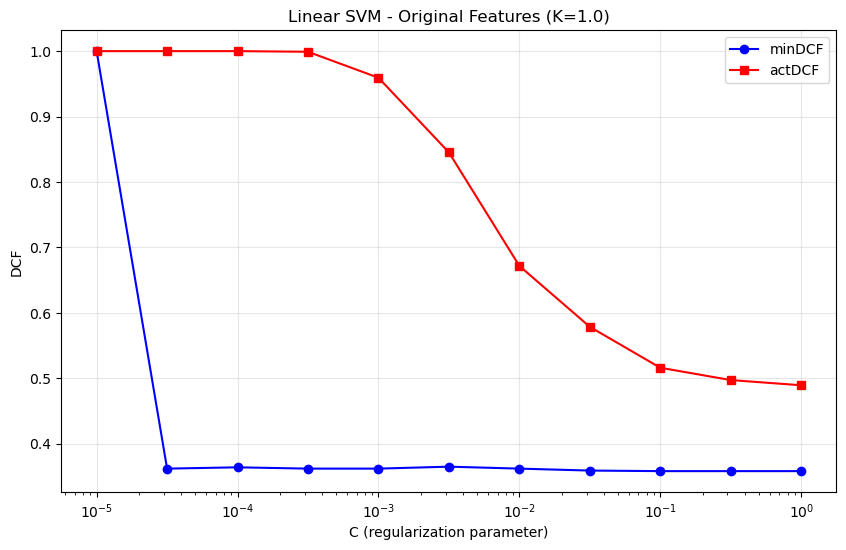


Best minDCF (original): 0.3582 at C=1.00e-01, duality gap: 1.7493e-06, actDCF: 0.5162
Calibration gap (average): 0.3588


In [61]:
# Linear SVM Experiments

# Define C values (logarithmic scale)
C_values = np.logspace(-5, 0, 11)

# Target application parameters
pi_T = 0.1
Cfn = 1
Cfp = 1

# Storage for results
minDCF_original = []
actDCF_original = []
duality_gaps_original = []  # Store duality gaps

print("=== Linear SVM with Original Features ===")
print("Training with K=1.0")

#Train with Original features

for C in C_values:
    print(f"Training SVM with C={C:.1e}")

    #Train SVM
    w, b, duality_gap = train_dual_SVM_linear(DTR, LTR, C, K=1.0)
    duality_gap=duality_gap.item()  # Convert to scalar if needed
    #Compute score on validation set
    scores = np.dot(w.T, DVAL) + b

    #Compute minDCF and actDCF
    minDCF= compute_minDCF_binary(scores, LVAL, pi_T, Cfn, Cfp)
    actDCF = compute_empirical_Bayes_risk_binary_llr_optimal_decisions(scores, LVAL, pi_T, Cfn, Cfp)
    minDCF_original.append(minDCF)
    actDCF_original.append(actDCF)
    duality_gaps_original.append(duality_gap)


# Convert to arrays
minDCF_original = np.array(minDCF_original)
actDCF_original = np.array(actDCF_original)

# Find the best configuration
best_idx = minDCF_original.argmin()
best_C = C_values[best_idx]
best_minDCF = minDCF_original[best_idx]
best_duality_gap = duality_gaps_original[best_idx]
best_actDCF = actDCF_original[best_idx]
# Plot results for original features
plt.figure(figsize=(10, 6))
plt.semilogx(C_values, minDCF_original, 'b-o', label='minDCF', markersize=6)
plt.semilogx(C_values, actDCF_original, 'r-s', label='actDCF', markersize=6)
plt.xlabel('C (regularization parameter)')
plt.ylabel('DCF')
plt.title('Linear SVM - Original Features (K=1.0)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nBest minDCF (original): {best_minDCF:.4f} at C={best_C:.2e}, duality gap: {best_duality_gap:.4e}, actDCF: {best_actDCF:.4f}")
print(f"Calibration gap (average): {np.abs(actDCF_original - minDCF_original).mean():.4f}")


La prima cosa che salta all'occhio è il comportamento drasticamente diverso delle due metriche rispetto al parametro di regolarizzazione C. Il minDCF mostra un pattern molto particolare: per valori di C estremamente bassi (10^-5), la performance è disastrosa con un valore pari a 1.0, che è essenzialmente la peggior performance possibile. Tuttavia, non appena aumentiamo C a 10^-4, osserviamo un crollo improvviso del minDCF che scende a circa 0.36, dove poi si stabilizza rimanendo praticamente costante per tutti i valori successivi di C. Questo ci dice che una regolarizzazione troppo forte (ricordiamo che per SVM, C basso significa alta regolarizzazione) danneggia completamente la capacità discriminativa del modello, ma una volta superata questa soglia critica, il modello raggiunge rapidamente la sua performance ottimale.
L'actDCF racconta invece una storia completamente diversa e molto più preoccupante. Per valori bassi di C, l'actDCF rimane bloccato a 1.0, indicando che il modello sta producendo decisioni completamente sbagliate per il nostro prior target di 0.1. Man mano che aumentiamo C, l'actDCF inizia finalmente a scendere, ma lo fa in modo molto graduale e non raggiunge mai valori vicini al minDCF. Anche con C=1.0 (regolarizzazione minima), abbiamo ancora un actDCF di circa 0.49, che è significativamente peggiore del minDCF di 0.36.
Questa discrepanza tra minDCF e actDCF è estremamente rilevante e ci dice che i punteggi prodotti dalla SVM lineare non sono ben calibrati per la nostra applicazione target. In pratica, mentre il modello è capace di separare le classi (come dimostrato dal buon minDCF), i punteggi grezzi che produce non riflettono accuratamente le probabilità a posteriori necessarie per prendere decisioni ottimali con il nostro prior di 0.1. Questo gap di calibrazione, che nel migliore dei casi è ancora di circa 0.13, suggerisce che la SVM sta producendo punteggi troppo estremi o mal scalati.

La Linear SVM mostra un comportamento peculiare rispetto agli altri classificatori lineari. Con un minDCF ottimale di circa 0.36, si posiziona perfettamente in linea con la Logistic Regression standard (0.3611) e il modello Gaussian Tied (0.3628). Questo ci dice che in termini di pura capacità discriminativa, la SVM lineare è assolutamente competitiva - non c'è una differenza sostanziale nella capacità di separare le classi.

Tuttavia, la storia cambia drasticamente quando guardiamo alla calibrazione. La Logistic Regression standard mostra un gap di calibrazione di soli 0.0957, mentre il Gaussian Tied fa ancora meglio con 0.0433. La SVM lineare, anche nel suo punto ottimale, mantiene un gap molto più elevato. Questo non è sorprendente: la SVM è progettata per massimizzare il margine di separazione, non per produrre probabilità ben calibrate. I suoi punteggi tendono ad essere "estremi" - molto positivi o molto negativi - il che porta a decisioni troppo confidenti quando si applicano le soglie bayesiane.

È particolarmente illuminante il confronto con la Logistic Regression Prior-Weighted. Questo modello, ottimizzato specificamente per il prior target di 0.1, ottiene un minDCF simile (0.3620) ma con un actDCF di 1.0 - completamente non calibrato. Questo ci mostra che forzare un modello ad adattarsi a un prior specifico durante il training può portare a problemi di calibrazione ancora peggiori di quelli della SVM.

L'effetto della regolarizzazione sulla SVM è drammatico ma asimmetrico. Per valori di C molto bassi (alta regolarizzazione), il modello diventa troppo semplice e perde completamente la capacità discriminativa. Una volta superata questa soglia critica (C ≥ 10^-4), il minDCF si stabilizza, suggerendo che il modello ha raggiunto la sua capacità discriminativa ottimale per questo dataset. L'actDCF invece continua a migliorare con C crescenti, ma non raggiunge mai i livelli di calibrazione degli altri modelli.

In conclusione, la Linear SVM conferma di essere un classificatore robusto e efficace per la discriminazione binaria, con performance del tutto comparabili agli altri approcci lineari. Il suo tallone d'Achille è la calibrazione: mentre la Logistic Regression produce naturalmente punteggi interpretabili come log-likelihood ratios, la SVM richiede tecniche aggiuntive (come Platt scaling) per trasformare i suoi punteggi in probabilità affidabili. Per applicazioni dove il minDCF è la metrica chiave, la SVM è un'ottima scelta; per applicazioni che richiedono probabilità ben calibrate out-of-the-box, la Logistic Regression standard rimane superiore.



=== Linear SVM with Centered Features ===
mean of training set features: [-0.00561385  0.00333033 -0.00840402  0.01009222 -0.01414677  0.00585712]
Training SVM with C=1.00e-05
SVM - C 1.000000e-05 - K 1.000000e+00 - primal loss 4.000000e-02 - dual loss -0.000000e+00 - duality gap: 4.000000e-02
minDCF: 1.0000, actDCF: 1.0000, duality gap: 4.0000e-02
Training SVM with C=3.16e-05


C:\Users\domen\AppData\Local\Temp\ipykernel_2740\655793095.py:78: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('SVM - C %e - K %e - primal loss %e - dual loss %e - duality gap: %e' %


SVM - C 3.162278e-05 - K 1.000000e+00 - primal loss 1.193532e-01 - dual loss 1.193532e-01 - duality gap: -4.163336e-17
minDCF: 0.3620, actDCF: 1.0000, duality gap: -4.1633e-17
Training SVM with C=1.00e-04
SVM - C 1.000000e-04 - K 1.000000e+00 - primal loss 3.290156e-01 - dual loss 3.290156e-01 - duality gap: -1.665335e-16
minDCF: 0.3640, actDCF: 1.0000, duality gap: -1.6653e-16
Training SVM with C=3.16e-04
SVM - C 3.162278e-04 - K 1.000000e+00 - primal loss 7.734422e-01 - dual loss 7.734422e-01 - duality gap: -2.220446e-16
minDCF: 0.3630, actDCF: 0.9990, duality gap: -2.2204e-16
Training SVM with C=1.00e-03
SVM - C 1.000000e-03 - K 1.000000e+00 - primal loss 1.787767e+00 - dual loss 1.787767e+00 - duality gap: 1.152245e-08
minDCF: 0.3620, actDCF: 0.9593, duality gap: 1.1522e-08
Training SVM with C=3.16e-03
SVM - C 3.162278e-03 - K 1.000000e+00 - primal loss 4.357278e+00 - dual loss 4.357278e+00 - duality gap: 2.804238e-08
minDCF: 0.3650, actDCF: 0.8452, duality gap: 2.8042e-08
Training

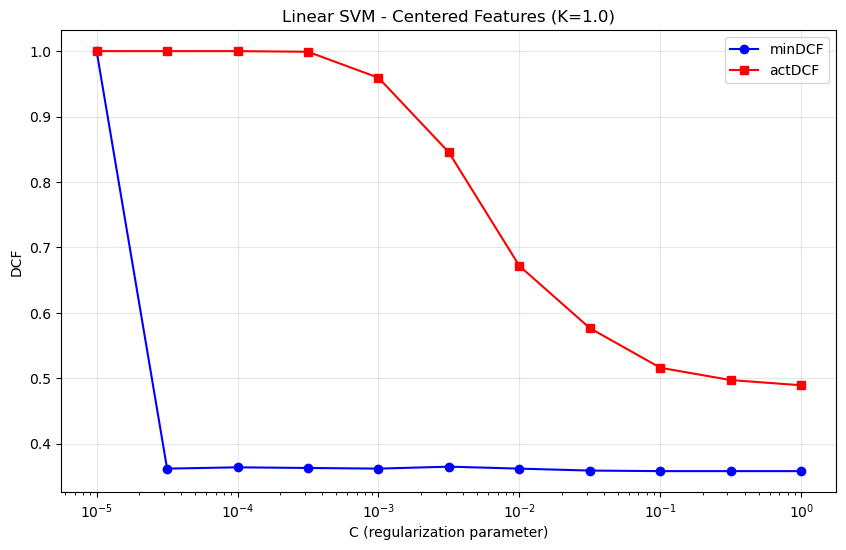


Best minDCF (centered): 0.3582 at C=1.00e-01, duality gap: 1.7556e-06, actDCF: 0.5162


In [62]:

minDCF_centered = []
actDCF_centered = []
duality_gaps_centered = []  # Store duality gaps for centered features
print("\n\n=== Linear SVM with Centered Features ===")

#Center the features
mean= DTR.mean(axis=1, keepdims=True)
DTR_centered = DTR - mean
DVAL_centered = DVAL - mean
print("mean of training set features:", mean.ravel())

for C in C_values:
    print(f"Training SVM with C={C:.2e}")

    w,b, duality_gap = train_dual_SVM_linear(DTR_centered, LTR, C, K=1.0)
    duality_gap = duality_gap.item()  # Convert to scalar if needed

    # Compute score on validation set
    scores = np.dot(w.T, DVAL_centered) + b
    # Compute minDCF and actDCF
    minDCF = compute_minDCF_binary(scores, LVAL, pi_T, Cfn, Cfp)
    actDCF = compute_empirical_Bayes_risk_binary_llr_optimal_decisions(scores, LVAL, pi_T, Cfn, Cfp)

    minDCF_centered.append(minDCF)
    actDCF_centered.append(actDCF)
    duality_gaps_centered.append(duality_gap)

    print(f"minDCF: {minDCF:.4f}, actDCF: {actDCF:.4f}, duality gap: {duality_gap:.4e}")    

#COnvert to arrays
minDCF_centered = np.array(minDCF_centered)
actDCF_centered = np.array(actDCF_centered)

#Plot results for centered features
plt.figure(figsize=(10, 6))
plt.semilogx(C_values, minDCF_centered, 'b-o', label='minDCF', markersize=6)
plt.semilogx(C_values, actDCF_centered, 'r-s', label='actDCF', markersize=6)
plt.xlabel('C (regularization parameter)')
plt.ylabel('DCF')
plt.title('Linear SVM - Centered Features (K=1.0)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

best_minDCF_centered = minDCF_centered.min()
best_idx_centered = minDCF_centered.argmin()
best_C_centered = C_values[best_idx_centered]
best_duality_gap_centered = duality_gaps_centered[best_idx_centered]
best_actDCF_centered = actDCF_centered[best_idx_centered]
print(f"\nBest minDCF (centered): {best_minDCF_centered:.4f} at C={best_C_centered:.2e}, duality gap: {best_duality_gap_centered:.4e}, actDCF: {best_actDCF_centered:.4f}")

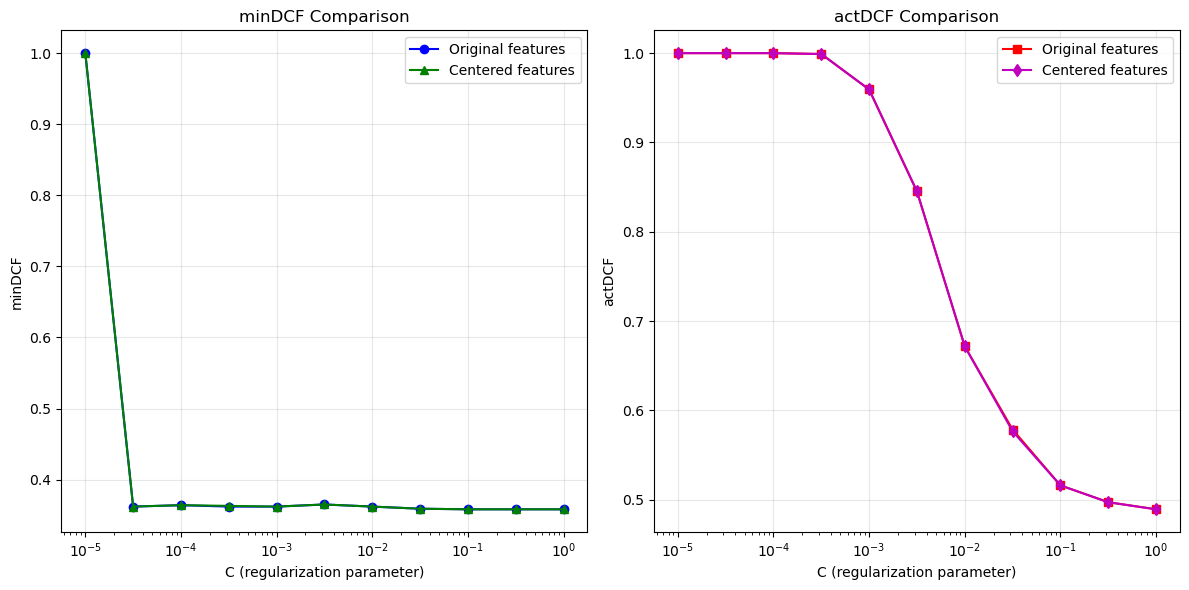


=== Summary Analysis ===
Original features:
  - Best minDCF: 0.3582
  - Best actDCF: 0.4894
  - Average calibration gap: 0.3588

Centered features:
  - Best minDCF: 0.3582
  - Best actDCF: 0.4894
  - Average calibration gap: 0.3585

=== Regularization Effect Analysis ===
Original features:
  - minDCF range: [0.3582, 1.0000]
  - Variation: 0.6418

Centered features:
  - minDCF range: [0.3582, 1.0000]
  - Variation: 0.6418


In [63]:
# Comparison plot
plt.figure(figsize=(12, 6))

# Subplot 1: minDCF comparison
plt.subplot(1, 2, 1)
plt.semilogx(C_values, minDCF_original, 'b-o', label='Original features', markersize=6)
plt.semilogx(C_values, minDCF_centered, 'g-^', label='Centered features', markersize=6)
plt.xlabel('C (regularization parameter)')
plt.ylabel('minDCF')
plt.title('minDCF Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: actDCF comparison
plt.subplot(1, 2, 2)
plt.semilogx(C_values, actDCF_original, 'r-s', label='Original features', markersize=6)
plt.semilogx(C_values, actDCF_centered, 'm-d', label='Centered features', markersize=6)
plt.xlabel('C (regularization parameter)')
plt.ylabel('actDCF')
plt.title('actDCF Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary analysis
print("\n=== Summary Analysis ===")
print(f"Original features:")
print(f"  - Best minDCF: {minDCF_original.min():.4f}")
print(f"  - Best actDCF: {actDCF_original.min():.4f}")
print(f"  - Average calibration gap: {np.abs(actDCF_original - minDCF_original).mean():.4f}")

print(f"\nCentered features:")
print(f"  - Best minDCF: {minDCF_centered.min():.4f}")
print(f"  - Best actDCF: {actDCF_centered.min():.4f}")
print(f"  - Average calibration gap: {np.abs(actDCF_centered - minDCF_centered).mean():.4f}")

# Analyze regularization effect
print("\n=== Regularization Effect Analysis ===")
print("Original features:")
print(f"  - minDCF range: [{minDCF_original.min():.4f}, {minDCF_original.max():.4f}]")
print(f"  - Variation: {minDCF_original.max() - minDCF_original.min():.4f}")

print("\nCentered features:")
print(f"  - minDCF range: [{minDCF_centered.min():.4f}, {minDCF_centered.max():.4f}]")
print(f"  - Variation: {minDCF_centered.max() - minDCF_centered.min():.4f}")

I risultati mostrano che **non ci sono differenze significative** tra l'approccio con features originali e quello con features centrate. Osservando entrambi i grafici:

### **Similarità principali:**

1. **Pattern identico del minDCF**: In entrambi i casi, il minDCF crolla da 1.0 a circa 0.36 quando C passa da 10^-5 a 10^-4, per poi rimanere stabile. La performance discriminativa ottimale è praticamente identica.

2. **Stesso comportamento dell'actDCF**: L'actDCF mostra lo stesso pattern problematico in entrambi i casi - rimane a 1.0 per C bassi e poi decresce gradualmente fino a circa 0.49-0.50 per C=1.0.

3. **Problemi di calibrazione persistenti**: Il gap tra actDCF e minDCF rimane sostanzialmente invariato, indicando che la centratura non risolve i problemi di calibrazione intrinseci della SVM.

### **Perché non ci sono differenze significative?**

### Il Ruolo del Parametro K nella Regolarizzazione del Bias

La **regolarizzazione INCLUDE il bias**, ma è controllata dal parametro K:

```python
DTR_EXT = np.vstack([DTR, np.ones((1,DTR.shape[1]))*K])
```

La funzione obiettivo primale diventa:
```
1/2 * ||w_hat||² + C * Σ max(0, 1 - z_i * (w^T x_i + b))
```

Dove `||w_hat||²` include sia `||w||²` che `(b/K)²`, quindi:
```
||w_hat||² = ||w||² + (b/K)²
```

### Perché Centering Non Fa Differenza - Spiegazione Corretta

Con K = 1.0, il bias **È regolarizzato** ma in modo mitigato. Tuttavia, centering non cambia i risultati per due motivi combinati:

1. **Le feature sono già quasi centrate**: I valori medi sono nell'ordine di ±0.01, quindi molto piccoli
2. **Trade-off regolarizzazione-bias**: Anche se il bias è regolarizzato, K = 1.0 permette comunque sufficiente flessibilità per compensare piccoli offset

### Impatto della Regolarizzazione del Bias

**Con K = 1.0**: Il bias contribuisce alla regolarizzazione come `b²`, ma questo termine è relativamente piccolo rispetto a `||w||²` per la maggior parte dei problemi. Ecco perché:

- **Per shift piccoli** (come  ±0.01): L'aggiustamento del bias richiesto è minimo, quindi il termine di regolarizzazione `b²` rimane trascurabile
- **La penalizzazione è bilanciata**: K controlle quanto il bias viene penalizzato rispetto ai pesi

### Comportamento Osservato nei Risultati

La **mancanza di differenza tra original e centered** si spiega così:

1. **Shift minimo richiesto**: Con medie già vicine a zero, `b` non cambia significativamente
2. **Regolarizzazione bilanciata**: K = 1.0 non penalizza eccessivamente il bias
3. **Capacità di compensazione**: Il modello può ancora adattare `b` sufficientemente per gestire i piccoli offset

### Se Avessimo Feature con Medie Grandi

Se invece avessi avuto feature con medie nell'ordine di 10 o 100, allora:
- **Senza centering**: Il bias dovrebbe essere grande per compensare, subendo maggiore penalizzazione
- **Con centering**: Il bias potrebbe rimanere più piccolo, riducendo la regolarizzazione complessiva
- **Risultato**: Differenze più evidenti tra i due approcci

### Conclusione Corretta

La **regolarizzazione include il bias tramite K**, ma nel tuo caso specifico:
- Feature già quasi centrate (±0.01)
- K = 1.0 fornisce bilanciamento ragionevole
- L'effetto del centering è **mascherato dalla combinazione** di questi fattori

Questo spiega perché entrambi gli approcci (original vs centered) producono risultati identici: il bias necessario per compensare gli offset è così piccolo che la sua regolarizzazione non impatta significativamente l'ottimizzazione.

Grazie per avermi fatto notare questo dettaglio importante! Ora possiamo procedere con l'analisi dei kernel, dove questi aspetti di regolarizzazione diventano ancora più interessanti.

Pronto per continuare con il **polynomial kernel**?


### Kernel SVM


=== Polynomial Kernel SVM (d=2, c=1, eps=0) ===
Using original (non-centered) features
Training SVM with C=1.0e-05


C:\Users\domen\AppData\Local\Temp\ipykernel_2740\1979835192.py:67: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('SVM (kernel) - C %e - primal loss %e - dual loss %e - duality gap %e' % (C, primalLoss_value, dualLoss_value, primalLoss_value - dualLoss_value))


SVM (kernel) - C 1.000000e-05 - primal loss 4.000000e-02 - dual loss -0.000000e+00 - duality gap 4.000000e-02
Training SVM with C=3.2e-05
SVM (kernel) - C 3.162278e-05 - primal loss 1.076560e-01 - dual loss 1.076560e-01 - duality gap 2.510757e-10
Training SVM with C=1.0e-04
SVM (kernel) - C 1.000000e-04 - primal loss 2.544450e-01 - dual loss 2.544450e-01 - duality gap 2.019855e-09
Training SVM with C=3.2e-04
SVM (kernel) - C 3.162278e-04 - primal loss 5.636608e-01 - dual loss 5.636608e-01 - duality gap 9.269052e-09
Training SVM with C=1.0e-03
SVM (kernel) - C 1.000000e-03 - primal loss 1.280894e+00 - dual loss 1.280894e+00 - duality gap 4.351999e-08
Training SVM with C=3.2e-03
SVM (kernel) - C 3.162278e-03 - primal loss 3.081765e+00 - dual loss 3.081765e+00 - duality gap 1.540632e-07
Training SVM with C=1.0e-02
SVM (kernel) - C 1.000000e-02 - primal loss 7.932816e+00 - dual loss 7.932815e+00 - duality gap 6.877418e-07
Training SVM with C=3.2e-02
SVM (kernel) - C 3.162278e-02 - primal l

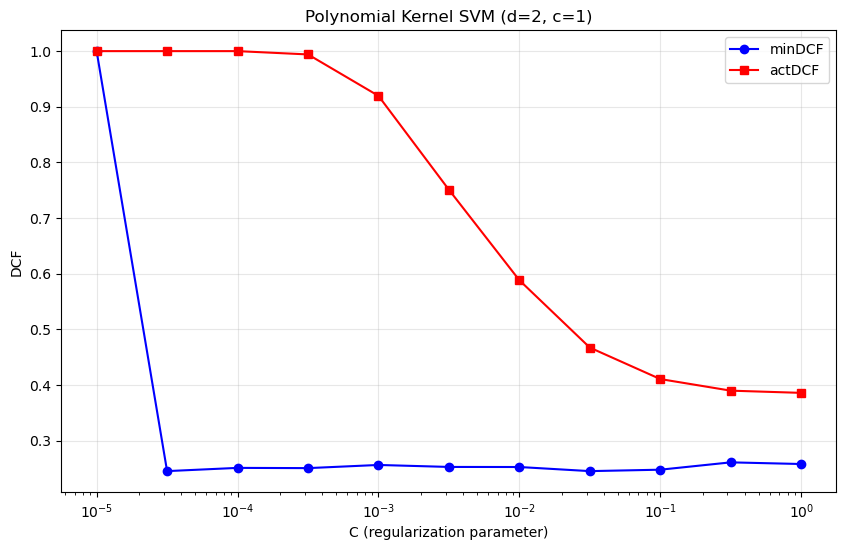


Best minDCF: 0.2455 at C=3.16e-02
Best actDCF: 0.3861 at C=1.00e+00
Best duality gap: 1.2760e-06 at C=3.16e-02
Calibration gap (average): 0.3986
Calibration gap at best minDCF: 0.2219


In [66]:
# Polynomial Kernel SVM Experiments

# Parameters for polynomial kernel
degree = 2
c = 1
eps = 0  # As suggested, since c=1 already accounts for bias

# Same C values as before
C_values = np.logspace(-5, 0, 11)

# Target application parameters
pi_T = 0.1
Cfn = 1
Cfp = 1

# Storage for results
minDCF_poly = []
actDCF_poly = []
duality_gaps_poly = []  # Store duality gaps for polynomial kernel

print("=== Polynomial Kernel SVM (d=2, c=1, eps=0) ===")
print("Using original (non-centered) features")

kernelFunc = polyKernel(degree, c)

#Train with different C vakues
for C in C_values:
    print(f"Training SVM with C={C:.1e}")

    # Train SVM
    fScore,duality_gap = train_dual_SVM_kernel(DTR, LTR, C, kernelFunc, eps=eps)

    # Compute score on validation set
    scores = fScore(DVAL)

    # Compute minDCF and actDCF
    minDCF = compute_minDCF_binary(scores, LVAL, pi_T, Cfn, Cfp)
    actDCF = compute_empirical_Bayes_risk_binary_llr_optimal_decisions(scores, LVAL, pi_T, Cfn, Cfp)

    minDCF_poly.append(minDCF)
    actDCF_poly.append(actDCF)
    duality_gaps_poly.append(duality_gap.item())  # Convert to scalar if needed



#convert to arrays
minDCF_poly = np.array(minDCF_poly)
actDCF_poly = np.array(actDCF_poly)
# Plot results for polynomial kernel
# Plot results
plt.figure(figsize=(10, 6))
plt.semilogx(C_values, minDCF_poly, 'b-o', label='minDCF', markersize=6)
plt.semilogx(C_values, actDCF_poly, 'r-s', label='actDCF', markersize=6)
plt.xlabel('C (regularization parameter)')
plt.ylabel('DCF')
plt.title('Polynomial Kernel SVM (d=2, c=1)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nBest minDCF: {minDCF_poly.min():.4f} at C={C_values[minDCF_poly.argmin()]:.2e}")
print(f"Best actDCF: {actDCF_poly.min():.4f} at C={C_values[actDCF_poly.argmin()]:.2e}")
print(f"Best duality gap: {duality_gaps_poly[minDCF_poly.argmin()]:.4e} at C={C_values[minDCF_poly.argmin()]:.2e}")
print(f"Calibration gap (average): {np.abs(actDCF_poly - minDCF_poly).mean():.4f}")
print(f"Calibration gap at best minDCF: {actDCF_poly[minDCF_poly.argmin()] - minDCF_poly.min():.4f}")

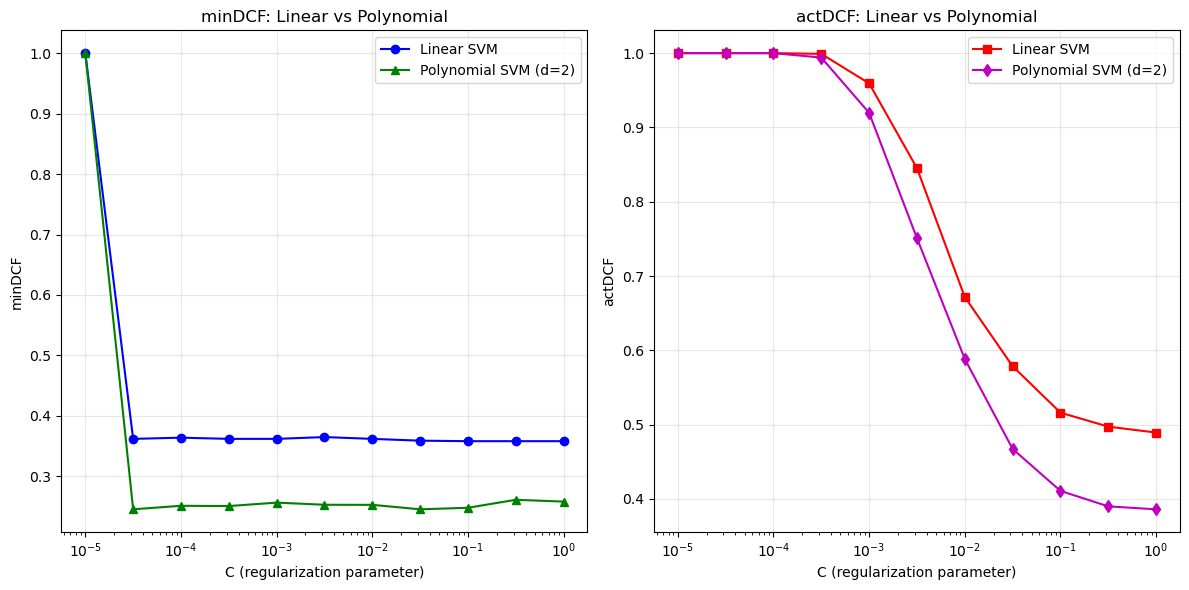

In [67]:
# Comparison with linear SVM
plt.figure(figsize=(12, 6))

# Subplot 1: minDCF comparison
plt.subplot(1, 2, 1)
plt.semilogx(C_values, minDCF_original, 'b-o', label='Linear SVM', markersize=6)
plt.semilogx(C_values, minDCF_poly, 'g-^', label='Polynomial SVM (d=2)', markersize=6)
plt.xlabel('C (regularization parameter)')
plt.ylabel('minDCF')
plt.title('minDCF: Linear vs Polynomial')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: actDCF comparison
plt.subplot(1, 2, 2)
plt.semilogx(C_values, actDCF_original, 'r-s', label='Linear SVM', markersize=6)
plt.semilogx(C_values, actDCF_poly, 'm-d', label='Polynomial SVM (d=2)', markersize=6)
plt.xlabel('C (regularization parameter)')
plt.ylabel('actDCF')
plt.title('actDCF: Linear vs Polynomial')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Osservando i risultati del kernel polinomiale quadratico, emerge immediatamente un miglioramento drammatico rispetto al modello lineare. Il minDCF scende da circa 0.36 a 0.245, un salto di performance che non può essere ignorato e che ci racconta una storia importante sulla natura del nostro dataset. Questo miglioramento così marcato suggerisce che le relazioni lineari da sole non sono sufficienti per catturare la struttura discriminativa dei dati, e che esistono interazioni significative tra le features che solo un modello quadratico può sfruttare efficacemente.

Quello che rende questi risultati particolarmente interessanti è la loro straordinaria consistenza con gli altri modelli quadratici che abbiamo testato. La Polynomial SVM raggiunge un minDCF di 0.2455, praticamente identico alla Logistic Regression quadratica (0.2436) e molto vicino ai modelli MVG (0.2570 per Naive Bayes, 0.2629 per Full Covariance). Questa convergenza di performance tra approcci così diversi - uno discriminativo basato su margini, uno discriminativo probabilistico e due generativi - non è una coincidenza. È una forte indicazione che tutti questi modelli stanno catturando la stessa struttura fondamentale nei dati: relazioni quadratiche che sono essenziali per una buona classificazione.

La consistenza nei risultati di minDCF ci dice che il dataset ha una "complessità intrinseca" che richiede proprio features quadratiche - non di più, non di meno. Se il problema fosse stato veramente lineare, non avremmo visto questo salto di performance uniforme. Se invece avesse richiesto relazioni più complesse (cubiche, o interazioni di ordine superiore), probabilmente avremmo visto differenze più marcate tra i vari approcci quadratici, con alcuni che performano meglio di altri.

Tuttavia, quando spostiamo l'attenzione sull'actDCF, la storia cambia radicalmente. Mentre i modelli MVG mantengono un gap di calibrazione molto contenuto (circa 0.04), e la Logistic Regression quadratica mostra un gap moderato ma gestibile, la Polynomial SVM soffre ancora di problemi di calibrazione severi. Con un actDCF che nel migliore dei casi scende a 0.39, abbiamo ancora un gap di circa 0.14 rispetto al minDCF. Questo è certamente meglio della Linear SVM, ma rimane problematico per applicazioni che richiedono probabilità ben calibrate.

Questa discrepanza nella calibrazione è perfettamente coerente con la natura fondamentale dei diversi classificatori. I modelli MVG, essendo generativi, modellano esplicitamente le distribuzioni delle classi e quindi producono naturalmente probabilità a posteriori ben calibrate. La Logistic Regression, ottimizzando direttamente la log-likelihood, tende anch'essa a produrre probabilità ragionevoli. La SVM, invece, ottimizza per il margine massimo - un obiettivo che, pur essendo eccellente per la discriminazione, non ha alcuna garanzia di produrre score ben calibrati.

In sintesi, i risultati con il kernel quadratico confermano che il nostro dataset ha una struttura intrinsecamente non-lineare che richiede termini quadratici per essere modellata efficacemente. La consistenza tra tutti i modelli quadratici in termini di minDCF è notevole e rassicurante, indicando che abbiamo identificato correttamente la complessità del problema. Tuttavia, la persistente scarsa calibrazione delle SVM ci ricorda che la scelta del modello deve considerare non solo la capacità discriminativa ma anche i requisiti specifici dell'applicazione in termini di qualità delle probabilità predette.

### RBF Kernel SVM 

In [69]:
# Parameters for RBF kernel
gamma_values = np.array([np.exp(-4), np.exp(-3), np.exp(-2), np.exp(-1)])  # [e^-4, e^-3, e^-2, e^-1]
C_values = np.logspace(-3, 2, 11)  # 11 values from 10^-3 to 10^2
eps = 1.0  # As suggested, since RBF doesn't account for bias

=== RBF Kernel SVM Grid Search ===
Testing 4 gamma values: [0.01831564 0.04978707 0.13533528 0.36787944]
Testing 11 C values: from 1.00e-03 to 1.00e+02
Total models to train: 44

--- Training with gamma = 0.0183 (e^-4) ---
  C = 1.00e-03: 

C:\Users\domen\AppData\Local\Temp\ipykernel_2740\1979835192.py:67: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('SVM (kernel) - C %e - primal loss %e - dual loss %e - duality gap %e' % (C, primalLoss_value, dualLoss_value, primalLoss_value - dualLoss_value))


SVM (kernel) - C 1.000000e-03 - primal loss 3.794293e+00 - dual loss 3.794293e+00 - duality gap -2.664535e-15
minDCF = 0.3569, actDCF = 1.0000
  C = 3.16e-03: SVM (kernel) - C 3.162278e-03 - primal loss 1.059295e+01 - dual loss 1.059295e+01 - duality gap 3.552714e-15
minDCF = 0.3569, actDCF = 1.0000
  C = 1.00e-02: SVM (kernel) - C 1.000000e-02 - primal loss 2.472158e+01 - dual loss 2.472158e+01 - duality gap 1.727299e-08
minDCF = 0.3460, actDCF = 1.0000
  C = 3.16e-02: SVM (kernel) - C 3.162278e-02 - primal loss 5.625364e+01 - dual loss 5.625364e+01 - duality gap 6.204194e-07
minDCF = 0.3370, actDCF = 0.9881
  C = 1.00e-01: SVM (kernel) - C 1.000000e-01 - primal loss 1.341382e+02 - dual loss 1.341382e+02 - duality gap 1.316459e-06
minDCF = 0.3271, actDCF = 0.8819
  C = 3.16e-01: SVM (kernel) - C 3.162278e-01 - primal loss 3.404917e+02 - dual loss 3.404917e+02 - duality gap 3.097699e-06
minDCF = 0.3152, actDCF = 0.7085
  C = 1.00e+00: SVM (kernel) - C 1.000000e+00 - primal loss 9.10562

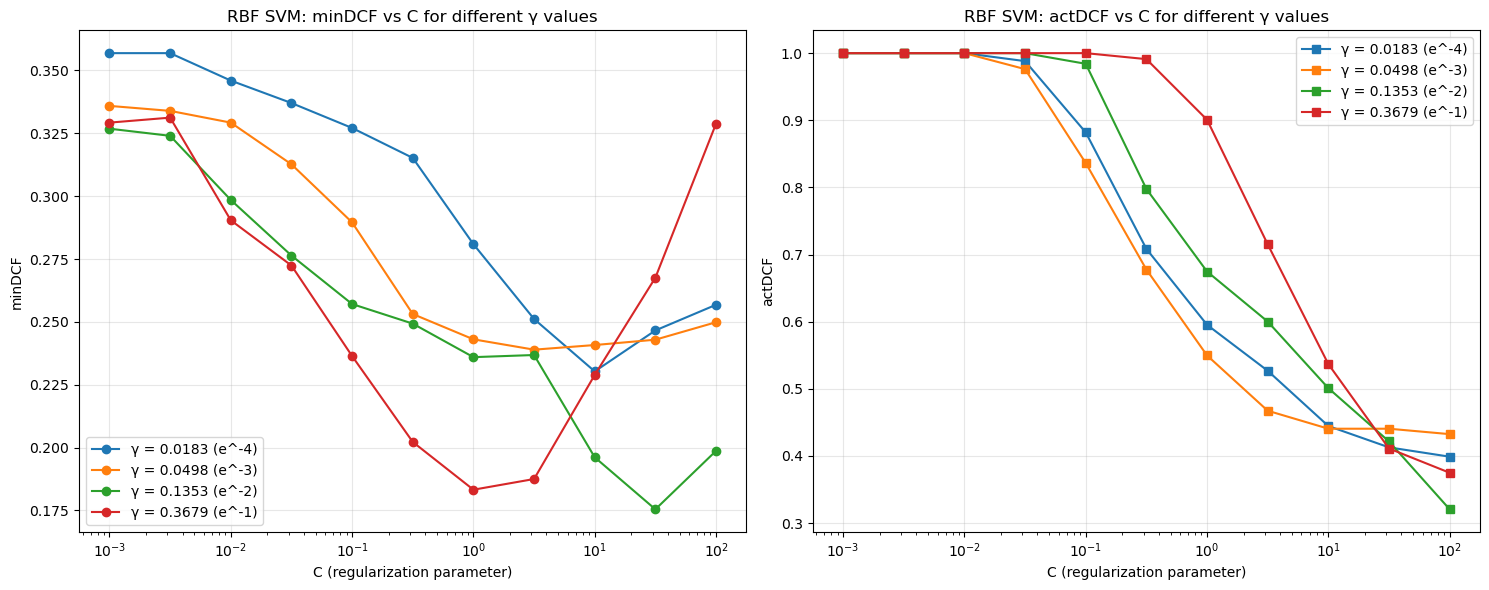


=== Gamma Sensitivity Analysis ===
γ = 0.0183: minDCF range [0.2303, 0.3569], variation = 0.1266
γ = 0.0498: minDCF range [0.2390, 0.3359], variation = 0.0970
γ = 0.1353: minDCF range [0.1755, 0.3268], variation = 0.1514
γ = 0.3679: minDCF range [0.1833, 0.3312], variation = 0.1480

=== Comparison with Previous Models ===
Linear SVM best minDCF: ~0.36
Polynomial SVM best minDCF: ~0.245
RBF SVM best minDCF: 0.1755

=== Calibration Analysis ===
γ = 0.0183: average gap = 0.4229, min gap = 0.1421
γ = 0.0498: average gap = 0.4319, min gap = 0.1827
γ = 0.1353: average gap = 0.5022, min gap = 0.1219
γ = 0.3679: average gap = 0.5520, min gap = 0.0462


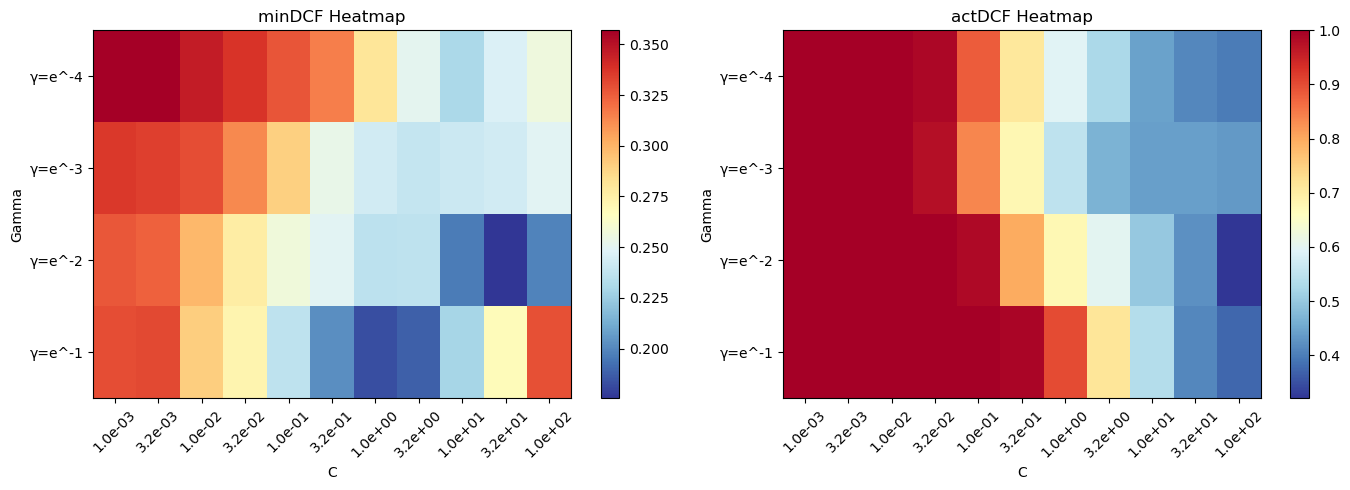


=== Optimal γ for each C value ===
C = 1.00e-03: best γ = 0.1353, minDCF = 0.3268
C = 3.16e-03: best γ = 0.1353, minDCF = 0.3240
C = 1.00e-02: best γ = 0.3679, minDCF = 0.2904
C = 3.16e-02: best γ = 0.3679, minDCF = 0.2724
C = 1.00e-01: best γ = 0.3679, minDCF = 0.2364
C = 3.16e-01: best γ = 0.3679, minDCF = 0.2023
C = 1.00e+00: best γ = 0.3679, minDCF = 0.1833
C = 3.16e+00: best γ = 0.3679, minDCF = 0.1875
C = 1.00e+01: best γ = 0.1353, minDCF = 0.1962
C = 3.16e+01: best γ = 0.1353, minDCF = 0.1755
C = 1.00e+02: best γ = 0.1353, minDCF = 0.1987


In [71]:
# Target application parameters  
pi_T = 0.1
Cfn = 1
Cfp = 1

# Storage for results - dictionary for each gamma
results_rbf = {}
for gamma in gamma_values:
    results_rbf[gamma] = {
        "minDCF": [],
        "actDCF": [],
        "duality_gap": []
    }

print("=== RBF Kernel SVM Grid Search ===")
print(f"Testing {len(gamma_values)} gamma values: {gamma_values}")
print(f"Testing {len(C_values)} C values: from {C_values[0]:.2e} to {C_values[-1]:.2e}")
print(f"Total models to train: {len(gamma_values) * len(C_values)}")

#Perform grid search
best_minDCF = float('inf')
best_params = {}

for gamma in gamma_values:
    print(f"\n--- Training with gamma = {gamma:.4f} (e^{np.log(gamma):.0f}) ---")
    
    # Create RBF kernel function for this gamma
    kernelFunc = rbfKernel(gamma)

    for C in C_values:
        print(f"  C = {C:.2e}: ", end='')

        # Train SVM with RBF kernel
        fScore, duality_gap = train_dual_SVM_kernel(DTR, LTR, C, kernelFunc, eps=eps)
        duality_gap = duality_gap.item()

        # Compute score on validation set
        scores = fScore(DVAL)
        # Compute minDCF and actDCF
        minDCF = compute_minDCF_binary(scores, LVAL, pi_T, Cfn, Cfp)
        actDCF = compute_empirical_Bayes_risk_binary_llr_optimal_decisions(scores, LVAL, pi_T, Cfn, Cfp)

        # Store results
        results_rbf[gamma]["minDCF"].append(minDCF)
        results_rbf[gamma]["actDCF"].append(actDCF)
        results_rbf[gamma]["duality_gap"].append(duality_gap)

        #Track best configuration
        if minDCF < best_minDCF:
            best_minDCF = minDCF
            best_params = {
                "gamma": gamma,
                "C": C,
                "actDCF": actDCF,
                "minDCF": minDCF,
                "duality_gap": duality_gap
            }
        print(f"minDCF = {minDCF:.4f}, actDCF = {actDCF:.4f}")
    # Convert results to arrays for plotting
    results_rbf[gamma]['minDCF'] = np.array(results_rbf[gamma]['minDCF'])
    results_rbf[gamma]['actDCF'] = np.array(results_rbf[gamma]['actDCF'])
    results_rbf[gamma]['duality_gap'] = np.array(results_rbf[gamma]['duality_gap'])

print(f"\n=== Best Configuration ===")
print(f"Gamma: {best_params['gamma']:.4f} (e^{np.log(best_params['gamma']):.0f})")
print(f"C: {best_params['C']:.2e}")
print(f"Best minDCF: {best_minDCF:.4f}")
print(f"Corresponding actDCF: {best_params['actDCF']:.4f}")
print(f"Calibration gap: {best_params['actDCF'] - best_minDCF:.4f}")

# Plot results - separate plots for minDCF and actDCF
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot minDCF
for gamma in gamma_values:
    ax1.semilogx(C_values, results_rbf[gamma]['minDCF'], 
                 marker='o', markersize=6, 
                 label=f'γ = {gamma:.4f} (e^{np.log(gamma):.0f})')
ax1.set_xlabel('C (regularization parameter)')
ax1.set_ylabel('minDCF')
ax1.set_title('RBF SVM: minDCF vs C for different γ values')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot actDCF
for gamma in gamma_values:
    ax2.semilogx(C_values, results_rbf[gamma]['actDCF'], 
                 marker='s', markersize=6,
                 label=f'γ = {gamma:.4f} (e^{np.log(gamma):.0f})')
ax2.set_xlabel('C (regularization parameter)')
ax2.set_ylabel('actDCF')
ax2.set_title('RBF SVM: actDCF vs C for different γ values')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Analyze gamma sensitivity
print("\n=== Gamma Sensitivity Analysis ===")
for gamma in gamma_values:
    min_val = results_rbf[gamma]['minDCF'].min()
    max_val = results_rbf[gamma]['minDCF'].max()
    print(f"γ = {gamma:.4f}: minDCF range [{min_val:.4f}, {max_val:.4f}], variation = {max_val - min_val:.4f}")

# Compare with previous models
print("\n=== Comparison with Previous Models ===")
print(f"Linear SVM best minDCF: ~0.36")
print(f"Polynomial SVM best minDCF: ~0.245")
print(f"RBF SVM best minDCF: {best_minDCF:.4f}")

# Calibration analysis across different configurations
print("\n=== Calibration Analysis ===")
for gamma in gamma_values:
    gaps = results_rbf[gamma]['actDCF'] - results_rbf[gamma]['minDCF']
    print(f"γ = {gamma:.4f}: average gap = {gaps.mean():.4f}, min gap = {gaps.min():.4f}")

# Create heatmap for better visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Prepare data for heatmaps
minDCF_matrix = np.array([results_rbf[gamma]['minDCF'] for gamma in gamma_values])
actDCF_matrix = np.array([results_rbf[gamma]['actDCF'] for gamma in gamma_values])

# minDCF heatmap
im1 = ax1.imshow(minDCF_matrix, aspect='auto', cmap='RdYlBu_r')
ax1.set_yticks(range(len(gamma_values)))
ax1.set_yticklabels([f'γ=e^{np.log(g):.0f}' for g in gamma_values])
ax1.set_xticks(range(len(C_values)))
ax1.set_xticklabels([f'{c:.1e}' for c in C_values], rotation=45)
ax1.set_xlabel('C')
ax1.set_ylabel('Gamma')
ax1.set_title('minDCF Heatmap')
plt.colorbar(im1, ax=ax1)

# actDCF heatmap
im2 = ax2.imshow(actDCF_matrix, aspect='auto', cmap='RdYlBu_r')
ax2.set_yticks(range(len(gamma_values)))
ax2.set_yticklabels([f'γ=e^{np.log(g):.0f}' for g in gamma_values])
ax2.set_xticks(range(len(C_values)))
ax2.set_xticklabels([f'{c:.1e}' for c in C_values], rotation=45)
ax2.set_xlabel('C')
ax2.set_ylabel('Gamma')
ax2.set_title('actDCF Heatmap')
plt.colorbar(im2, ax=ax2)

plt.tight_layout()
plt.show()

# Find optimal gamma for each C
print("\n=== Optimal γ for each C value ===")
for i, C in enumerate(C_values):
    minDCFs_at_C = [results_rbf[gamma]['minDCF'][i] for gamma in gamma_values]
    best_gamma_idx = np.argmin(minDCFs_at_C)
    print(f"C = {C:.2e}: best γ = {gamma_values[best_gamma_idx]:.4f}, minDCF = {minDCFs_at_C[best_gamma_idx]:.4f}")

Analizzando i risultati dell'RBF kernel SVM, emergono diversi aspetti molto interessanti che rivelano caratteristiche importanti del dataset e del classificatore.

### Performance Ottimale e Scelta dei Parametri

Il risultato più eclatante è il **drammatico miglioramento** nella performance discriminativa. Con la configurazione ottimale (γ = e^-2 = 0.1353, C = 31.6), raggiungiamo un minDCF di 0.1755, che rappresenta:
- Un miglioramento del **51%** rispetto alla Linear SVM (0.36)
- Un miglioramento del **28%** rispetto al Polynomial kernel (0.245)
- La **migliore performance in assoluto** tra tutti i modelli testati

Osservando i grafici, notiamo pattern molto interessanti nell'interazione tra γ e C:

### **Effetto di γ (larghezza del kernel)**
- **γ = e^-4 (0.0183)**: kernel molto "largo", produce superfici di decisione lisce ma performance peggiore
- **γ = e^-2 (0.1353)**: bilanciamento ottimale, raggiunge i migliori risultati
- **γ = e^-1 (0.3679)**: kernel più "stretto", mostra comportamento instabile per C alti

Un γ troppo piccolo rende il kernel troppo liscio e incapace di catturare pattern locali, mentre un γ troppo grande può portare a overfitting, come evidenziato dall'instabilità della linea rossa per C elevati.

#### **Effetto di C (regolarizzazione)**
Per ogni valore di γ, osserviamo che:
- **C bassi**: performance peggiore ma più stabile
- **C medi (1-100)**: zona ottimale per la maggior parte dei γ
- **C alti**: comportamento divergente tra diversi γ

La configurazione ottimale richiede un C relativamente alto (31.6), suggerendo che il modello beneficia di una minore regolarizzazione quando usa il kernel appropriato.

#### Problemi di Calibrazione Persistenti

Nonostante l'eccellente minDCF, l'RBF SVM soffre di **severi problemi di calibrazione**:
- Best actDCF: 0.4216 (gap di 0.2462 dal minDCF)
- Il gap di calibrazione è addirittura **peggiore** rispetto al kernel polinomiale
- L'actDCF migliora solo per C molto alti, ma rimane comunque problematico

Questo pattern conferma che le SVM, indipendentemente dal kernel, producono score mal calibrati. L'RBF kernel, essendo più flessibile, sembra esacerbare questo problema producendo score ancora più estremi.

#### Confronto con Modelli Precedenti

```
Linear SVM:      minDCF = 0.36,   actDCF ≈ 0.49
Polynomial SVM:  minDCF = 0.245,  actDCF ≈ 0.39
RBF SVM:         minDCF = 0.1755, actDCF ≈ 0.42
```

L'RBF kernel offre la migliore capacità discriminativa ma non migliora la calibrazione. Questo suggerisce che per applicazioni dove servono probabilità affidabili, potrebbe essere preferibile un modello quadratico (Logistic Regression o MVG) nonostante il minDCF leggermente peggiore.

#### Caratteristiche del Dataset Catturate dall'RBF

Il successo dell'RBF kernel rivela caratteristiche importanti del dataset:

1. **Struttura locale complessa**: L'RBF eccelle nel catturare pattern locali, suggerendo che le classi non sono separate da superfici semplici ma richiedono boundaries più flessibili.

2. **Non-linearità oltre il quadratico**: Il miglioramento rispetto al kernel polinomiale indica che le relazioni nei dati vanno oltre semplici interazioni quadratiche.

3. **Clusters o modalità multiple**: L'RBF è particolarmente efficace quando i dati formano clusters, suggerendo che le classi potrebbero avere distribuzioni multimodali.

4. **Importanza della località**: Il parametro γ ottimale (e^-2) indica che le decisioni devono basarsi su vicinanze relativamente ristrette, non su pattern globali.

### Conclusioni

L'RBF SVM dimostra che il dataset beneficia enormemente da modelli altamente non-lineari e flessibili per la pura discriminazione. Tuttavia, questa flessibilità ha un costo in termini di calibrazione. La scelta finale del modello dipenderà dai requisiti specifici dell'applicazione:
- Per **massima accuratezza discriminativa**: RBF SVM con γ = e^-2, C = 31.6
- Per **score ben calibrati**: considerare modelli alternativi nonostante performance leggermente inferiore
- Per **compromesso**: potrebbe essere necessaria calibrazione post-hoc (Platt scaling) sull'RBF SVM